<a href="https://colab.research.google.com/github/ZombieCait/cnn_course/blob/master/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Патракова Екатерина, РИМ-281226**

# Классификация возраста, пола и расы по лицу человека

Используйте публичные данные UTKfaces. https://susanqq.github.io/UTKFace/
В работе необходимо использовать данные Aligned&Cropped Faces, где произведены вырезы лиц с исходных изображений.

Изображения хранятся в формате jpg. В имени (почти!!!) каждого иображения имеется информации о человеке

$$[возраст]\_[пол]\_[раса]\_[время].jpg$$

Потребуются первые три параметра из названия каждого файлы.

В текущем файле реализована тренировка сверточной нейронной сети resnet50 для классификации возраста по фотографии. Текущая СНС используется с предобученными весами (transfer learning - перенос обучения) на датасете imagenet. Перенос обучения позволяет использовать веса сети с другого набора данных. Как правило, такой подход позволяет существенно поднять точность предсказания на новом наборе данных.

Задачи:
1. Переписать класс Dataset так, чтобы __getitem__ выдывал классы возраст, пол и раса. Задача регрессии для предсказания возраста является сложно, в этой связи будем решать ее как классификационную. Необходимо закодировать возраст в один из классов [(0, 5), (5, 14), (14, 30), (30, 45), (45, 60), (60, 120)], таким образом __getitem__ будет выдавать номер класса, которому принадлежит человек на фотографии.
Дополнительная задача (по желанию): при классификации ответом является возрастная, а не число. Можно получать возраст в числом выражении если использовать математическое ожидание по ответам нейронной сети. Для этого необходимо умножить ответы в виде Softmax на средние значения возраста в каждой группе и проссумировать все значения. 

2. Переписать класс Net. Добавить Mobilentv2 и Resnet34, так чтобы аргументом net можно было выбрать на основе какого экстрактора признаков построить сеть для классификации. Добавить дополнительные классификаторы для возраста и расы.

3. Обучить сеть. Попробуйте оптимизатор SGD и Adam. Визуализировать результаты на валидационном наборе данных.

Примечание: для тренировки лучше использовать GPU или colab.research.google.com с поддержкой GPU.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! ls drive/'My Drive'

'Colab Notebooks'    junior-program   segmentation     учеба
 crop_part1.tar.gz   news	      UTKFace.tar.gz


In [0]:
! tar zxf drive/'My Drive'/crop_part1.tar.gz crop_part1

In [0]:
! tar zxf drive/'My Drive'/UTKFace.tar.gz UTKFace

In [5]:
ls

crop_part1/  drive/  sample_data/  UTKFace/


In [6]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Ниже реализован класс Dataset, который имеет три обязательных метода __init__, __len__, __getitem__.

- __init__ происходит инициализация переменных датасета.
- __len__ возращает количество изображений в датасете.
- __getitem__ возвращает изображение в формате PIL и значения классов age, gender, race по индексу.

Размер изображения установить $224 \times 224$. В случае медленного обучения на процессоре параметр можно уменьшить, но потребуется произвести изменения в месте крепления экстрактора признаков и классификатора нейронной сети.

In [0]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, path, subset = 'train', test_part = 0.2, transform = None):
        'Initialization'
        self.path = path
        self.subset = subset
        self.transform = transform
        names = [it for it in os.listdir(path) if len(it.split('_')) > 3]
        
        names = [os.path.join(path, it) for it in names]
        np.random.seed(0)
        np.random.shuffle(names)
        if subset == 'train':
            self.ids = names[:int(len(names) * test_part)]
        elif subset == 'valid':
            self.ids = names[int(len(names) * test_part):]
        self.age_list = [(0, 5), (5,14), (14, 30), (30, 45), (45, 60), (60, 120)]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.ids)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.ids[index]
        image = Image.open(ID)

        labels=ID.split('/')[-1].split('_')
        age = int(labels[0])
        gender = int(labels[1])
        race = int(labels[2])

        for i in range(6):
            group_age = range(self.age_list[i][0], self.age_list[i][1])
            if age in group_age:
                age = i
        
        if self.transform:
            image = self.transform(image)
        
        return image, age, gender, race


def decode_labels(age, gender, race):
    gender_dict = {0:'male',
                   1:'female'}

    race_dict = {0:'White',
                 1:'Black',
                 2:'Asian',
                 3:'Indian',
                 4:'Not common race'}

    age_dict = {0:'0-5',
                1:'5-14',
                2:'14-30',
                3:'30-45',
                4:'45-60',
                5:'60+'}
    
    age = age_dict.get(age)
    gender = gender_dict.get(gender)
    race = race_dict.get(race)
    
    return age, gender, race

In [0]:
path_to_data = 'UTKFace'
train_data = Dataset(path_to_data, subset='train', test_part = 0.2, transform = T)
valid_data = Dataset(path_to_data, subset='valid', test_part = 0.2, transform = T)

In [9]:
print('train data len: ', train_data.__len__())
print('valid data len: ', valid_data.__len__())

train data len:  4741
valid data len:  18964


Ниже представлен пример получения изображения по индексу.

14-30 male Asian


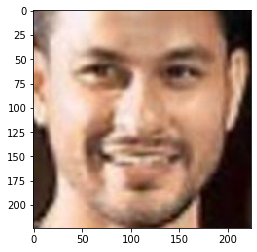

In [10]:
image, age, gender, race = train_data[138]
age, gender, race = decode_labels(age, gender, race)

print(age, gender, race)
plt.imshow(image.numpy().transpose(1,2,0))

Объекты train_data и valid_data передадим в DataLoader. Объект train_loader и valid_loader будут выдавать пачку изображения с правильными ответами (батчи).

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)

# download and transform test dataset
valid_loader = torch.utils.data.DataLoader(valid_data,
                                          batch_size=16, 
                                          shuffle=False)

('45-60', 'female', 'Indian')
('14-30', 'male', 'White')
('14-30', 'female', 'Black')
('45-60', 'female', 'White')
('0-5', 'female', 'Not common race')
('30-45', 'male', 'White')
('60+', 'male', 'Black')
('30-45', 'male', 'White')
('30-45', 'male', 'Black')
('30-45', 'female', 'Black')
('45-60', 'female', 'White')
('30-45', 'male', 'Black')
('14-30', 'female', 'Indian')
('60+', 'male', 'White')
('14-30', 'female', 'Black')
('0-5', 'male', 'Indian')


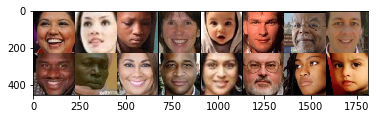

In [12]:
images, age, gender, race = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(images).numpy().transpose(1,2,0))

for i in range(len(age)):
    print(decode_labels(int(age[i]), int(gender[i]), int(race[i])))

In [0]:
import torch.nn as nn
from torchvision.models import mobilenet_v2, resnet34, resnet50
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, net='mobilenetv2', pretrained=True):
        super(Net, self).__init__()
        self.net = net
        if self.net == 'mobilenetv2':
            size = 1280 * 7 * 7
            self.model = models.mobilenet_v2(pretrained=True)
            self.model.classifier = nn.Dropout(p=0.2, inplace=False)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)

        elif self.net == 'resnet34':
            size=512
            self.model = models.resnet34(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)

        elif self.net == 'resnet50':
            size=2048
            self.model = models.resnet50(pretrained=True)
            self.model.gender_cls = nn.Linear(size, 2)
            self.model.age_cls = nn.Linear(size, 6)
            self.model.race_cls = nn.Linear(size, 5)

    def forward(self, x):
        if (self.net == 'resnet50') or (self.net == 'resnet34'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)
            
        if self.net == 'mobilenetv2':
            x = self.model.features(x)
            x = self.model.classifier(x)
            x = x.view(x.size(0), -1)
            gender = self.model.gender_cls(x)
            age = self.model.age_cls(x)
            race = self.model.race_cls(x)

        
        return age, gender, race

In [0]:
import torch.optim as optim

model_labels = ['resnet50', 'resnet34', 'mobilenetv2']
optimizer_labels = ['SGD', 'Adam']
NUMBER_OF_EPOCHS = 10
predict_limit = 1

Model:  resnet50
SGD  optimizer
Epoch 1, loss: 3.787, val_loss: 3.702 
 +            acc_age: 0.354, val_acc_age: 0.355 
  +            acc_gender: 0.537, val_acc_gender: 0.597 
  +            acc_race: 0.413, val_acc_race: 0.425
Epoch 2, loss: 3.646, val_loss: 3.606 
 +            acc_age: 0.369, val_acc_age: 0.360 
  +            acc_gender: 0.644, val_acc_gender: 0.674 
  +            acc_race: 0.424, val_acc_race: 0.427
Epoch 3, loss: 3.559, val_loss: 3.518 
 +            acc_age: 0.372, val_acc_age: 0.362 
  +            acc_gender: 0.700, val_acc_gender: 0.730 
  +            acc_race: 0.429, val_acc_race: 0.429
Epoch 4, loss: 3.469, val_loss: 3.433 
 +            acc_age: 0.375, val_acc_age: 0.369 
  +            acc_gender: 0.738, val_acc_gender: 0.748 
  +            acc_race: 0.431, val_acc_race: 0.443
Epoch 5, loss: 3.388, val_loss: 3.362 
 +            acc_age: 0.378, val_acc_age: 0.376 
  +            acc_gender: 0.757, val_acc_gender: 0.765 
  +            acc_race: 0.443

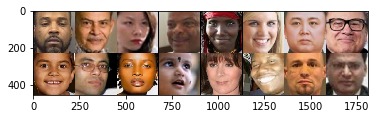

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')
Adam  optimizer
Epoch 1, loss: 2.903, val_loss: 2.556 
 +            acc_age: 0.467, val_acc_age: 0.495 
  +            acc_gender: 0.778, val_acc_gender: 0.831 
  +            acc_race: 0.578, val_acc_race: 0.614
Epoch 2, loss: 2.343, val_loss: 2.515 
 +            acc_age: 0.536, val_acc_age: 0.456 
  +            acc_gender: 0.835, val_acc_gender: 0.801 
  +            acc_race: 0.665, val_acc_race: 0.714
Epoch 3, lo

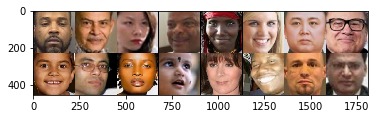

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')
Model:  resnet34


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 38.8MB/s]


SGD  optimizer
Epoch 1, loss: 4.019, val_loss: 3.782 
 +            acc_age: 0.289, val_acc_age: 0.342 
  +            acc_gender: 0.588, val_acc_gender: 0.621 
  +            acc_race: 0.348, val_acc_race: 0.411
Epoch 2, loss: 3.644, val_loss: 3.618 
 +            acc_age: 0.365, val_acc_age: 0.354 
  +            acc_gender: 0.671, val_acc_gender: 0.692 
  +            acc_race: 0.424, val_acc_race: 0.423
Epoch 3, loss: 3.492, val_loss: 3.484 
 +            acc_age: 0.377, val_acc_age: 0.364 
  +            acc_gender: 0.718, val_acc_gender: 0.729 
  +            acc_race: 0.434, val_acc_race: 0.444
Epoch 4, loss: 3.360, val_loss: 3.371 
 +            acc_age: 0.391, val_acc_age: 0.376 
  +            acc_gender: 0.748, val_acc_gender: 0.750 
  +            acc_race: 0.465, val_acc_race: 0.466
Epoch 5, loss: 3.250, val_loss: 3.262 
 +            acc_age: 0.399, val_acc_age: 0.392 
  +            acc_gender: 0.761, val_acc_gender: 0.767 
  +            acc_race: 0.484, val_acc_race: 0

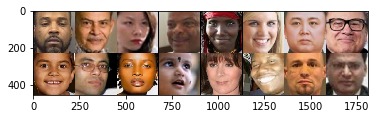

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')
Adam  optimizer
Epoch 1, loss: 2.789, val_loss: 2.426 
 +            acc_age: 0.489, val_acc_age: 0.541 
  +            acc_gender: 0.785, val_acc_gender: 0.837 
  +            acc_race: 0.582, val_acc_race: 0.635
Epoch 2, loss: 2.245, val_loss: 2.241 
 +            acc_age: 0.551, val_acc_age: 0.571 
  +            acc_gender: 0.849, val_acc_gender: 0.835 
  +            acc_race: 0.691, val_acc_race: 0.705
Epoch 3, lo

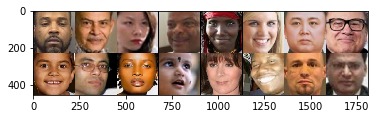

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')
Model:  mobilenetv2


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 9.27MB/s]


SGD  optimizer
Epoch 1, loss: 3.157, val_loss: 2.570 
 +            acc_age: 0.448, val_acc_age: 0.525 
  +            acc_gender: 0.736, val_acc_gender: 0.827 
  +            acc_race: 0.512, val_acc_race: 0.620
Epoch 2, loss: 2.387, val_loss: 2.373 
 +            acc_age: 0.572, val_acc_age: 0.555 
  +            acc_gender: 0.839, val_acc_gender: 0.842 
  +            acc_race: 0.648, val_acc_race: 0.660
Epoch 3, loss: 2.049, val_loss: 2.258 
 +            acc_age: 0.625, val_acc_age: 0.564 
  +            acc_gender: 0.868, val_acc_gender: 0.844 
  +            acc_race: 0.711, val_acc_race: 0.681
Epoch 4, loss: 1.836, val_loss: 2.189 
 +            acc_age: 0.677, val_acc_age: 0.572 
  +            acc_gender: 0.884, val_acc_gender: 0.854 
  +            acc_race: 0.745, val_acc_race: 0.696
Epoch 5, loss: 1.667, val_loss: 2.196 
 +            acc_age: 0.695, val_acc_age: 0.573 
  +            acc_gender: 0.902, val_acc_gender: 0.857 
  +            acc_race: 0.774, val_acc_race: 0

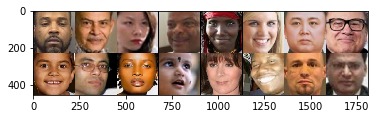

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')
Adam  optimizer
Epoch 1, loss: 6.006, val_loss: 2.577 
 +            acc_age: 0.429, val_acc_age: 0.533 
  +            acc_gender: 0.691, val_acc_gender: 0.792 
  +            acc_race: 0.499, val_acc_race: 0.613
Epoch 2, loss: 2.424, val_loss: 2.130 
 +            acc_age: 0.541, val_acc_age: 0.576 
  +            acc_gender: 0.829, val_acc_gender: 0.868 
  +            acc_race: 0.656, val_acc_race: 0.698
Epoch 3, lo

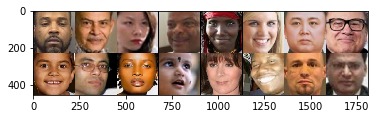

1 :     ('30-45', 'male', 'Black')
2 :     ('60+', 'male', 'Indian')
3 :     ('30-45', 'female', 'Asian')
4 :     ('60+', 'male', 'Black')
5 :     ('30-45', 'female', 'Black')
6 :     ('14-30', 'female', 'White')
7 :     ('30-45', 'male', 'Asian')
8 :     ('45-60', 'male', 'White')
9 :     ('5-14', 'male', 'Indian')
10 :     ('14-30', 'male', 'Indian')
11 :     ('14-30', 'female', 'Black')
12 :     ('0-5', 'female', 'Indian')
13 :     ('45-60', 'female', 'White')
14 :     ('14-30', 'male', 'Black')
15 :     ('14-30', 'male', 'White')
16 :     ('45-60', 'male', 'Indian')


In [16]:
from IPython.display import clear_output

for model_name in model_labels:
  print('Model: ', model_name)
  model = Net(net=model_name).to(device)
    
  for optimizer_name in optimizer_labels:
    print(str(optimizer_name), ' optimizer')

    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "SGD":
      optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)  
    elif optimizer_name == "Adam":
      optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    for epoch in range(NUMBER_OF_EPOCHS): 
        for phase in ['train', 'valid']:
           if phase == 'train':
              model.train(True)
    
              running_loss = 0.0
              correct = 0
              total = 0

              age_correct = 0
              gender_correct = 0
              race_correct = 0
            
              for i, data in enumerate(train_loader):
                  # get the inputs; data is a list of [inputs, labels]
                  inputs, age, gender, race  = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                  # zero the parameter gradients
                  optimizer.zero_grad()
                  # forward + backward + optimize
                  out_age, out_gender, out_race = model(inputs)

                  loss_age = criterion(out_age, age)
                  loss_gender = criterion(out_gender, gender)
                  loss_race = criterion(out_race, race)

                  loss = loss_age + loss_gender + loss_race
                  loss.backward()
                  optimizer.step()

                  # print statistics
                  running_loss += loss.item()
                  _, age_pred = torch.max(out_age.data, 1)
                  _, gender_pred = torch.max(out_gender.data, 1)
                  _, race_pred = torch.max(out_race.data, 1)
                  
                  total += gender.size(0)
                  age_correct += (age_pred == age).sum().item()
                  gender_correct += (gender_pred == gender).sum().item()
                  race_correct += (race_pred == race).sum().item()

        if phase == 'valid':
            model.train(False)
              
            validation_loss = 0
            v_correct = 0
            v_total = 0
            v_age_correct = 0
            v_gender_correct = 0
            v_race_correct = 0

            for i, v_data in enumerate(valid_loader):
                v_loss_age = 0
                v_loss_gender = 0
                v_loss_race = 0
                v_inputs, v_age, v_gender, v_race = v_data[0].to(device), v_data[1].to(device), v_data[2].to(device), v_data[3].to(device)

                v_out_age, v_out_gender, v_out_race = model(v_inputs)

                v_loss_age += criterion(v_out_age, v_age)
                v_loss_gender += criterion(v_out_gender, v_gender)
                v_loss_race += criterion(v_out_race, v_race)

                validation_loss += v_loss_age.item() + v_loss_gender.item() + v_loss_race.item()

                _, v_age_pred = torch.max(v_out_age.data, 1)
                _, v_gender_pred = torch.max(v_out_gender.data, 1)
                _, v_race_pred = torch.max(v_out_race.data, 1)

                v_total += v_gender.size(0)

                v_age_correct += (v_age_pred == v_age).sum().item()
                v_gender_correct += (v_gender_pred == v_gender).sum().item()
                v_race_correct += (v_race_pred == v_race).sum().item()


        print('Epoch %d, loss: %.3f, val_loss: %.3f \n +\
            acc_age: %.3f, val_acc_age: %.3f \n  +\
            acc_gender: %.3f, val_acc_gender: %.3f \n  +\
            acc_race: %.3f, val_acc_race: %.3f' %
              (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
                age_correct / total, v_age_correct / v_total,
                gender_correct / total, v_gender_correct / v_total,
                race_correct / total, v_race_correct / v_total,
              ))        

    print('Finished Training')

    for i in range(predict_limit):
                _, data = next(enumerate(valid_loader))
                inputs, age, gender, race = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)

                plt.imshow(torchvision.utils.make_grid(inputs).cpu().numpy().transpose(1,2,0))
                plt.show()
                out_age, out_gender, out_race = model(inputs)

                _, age_pred = torch.max(out_age.data, 1)
                _, gender_pred = torch.max(out_gender.data, 1)
                _, race_pred = torch.max(out_race.data, 1)

                for i in range(len(age)):
                  print(i+1, ":    ", decode_labels(int(age[i]), int(gender[i]), int(race[i])))